In [0]:
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.utils import np_utils
import tensorflow as tf
import numpy as np
from skimage.transform import resize

In [0]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [0]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	tr = []
	ts = []
	for i in trainX:
		downsampled_image = resize(i, [28, 28, 3])
		tr.append(np.reshape(rgb2gray(downsampled_image), (28, 28, 1)))
	for i in testX:
		downsampled_image = resize(i, [28, 28, 3])    
		ts.append(np.reshape(rgb2gray(downsampled_image), (28, 28, 1)))
    
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return np.array(tr), trainY, np.array(ts), testY

In [0]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [0]:
#both placeholders are of type float
x = tf.placeholder("float", [None,28,28, 1])
y = tf.placeholder("float", [None, 10])

In [0]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [0]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.initializers.he_uniform()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.initializers.he_uniform()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.initializers.he_uniform()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.initializers.he_uniform()), 
    'out': tf.get_variable('W6', shape=(128,10), initializer=tf.initializers.he_uniform()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.initializers.he_uniform()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.initializers.he_uniform()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.initializers.he_uniform()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.initializers.he_uniform()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.initializers.he_uniform()),
}

In [0]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)
   # conv1 = tf.contrib.layers.layer_norm(conv1)
    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)
    #conv2 = tf.contrib.layers.layer_norm(conv2)
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)
    #conv3 = tf.contrib.layers.layer_norm(conv3)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [0]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, momentum = 0.9).minimize(cost)

In [0]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
# Initializing the variables
init = tf.global_variables_initializer()
train_X, train_y, test_X, test_y = load_dataset()
training_iters = 100
batch_size = 64
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 1.741833, Training Accuracy= 0.43750
Optimization Finished!
Testing Accuracy: 0.37790
Iter 1, Loss= 1.600835, Training Accuracy= 0.48438
Optimization Finished!
Testing Accuracy: 0.43960
Iter 2, Loss= 1.510780, Training Accuracy= 0.56250
Optimization Finished!
Testing Accuracy: 0.47630
Iter 3, Loss= 1.416113, Training Accuracy= 0.56250
Optimization Finished!
Testing Accuracy: 0.50060
Iter 4, Loss= 1.337093, Training Accuracy= 0.57812
Optimization Finished!
Testing Accuracy: 0.52180
Iter 5, Loss= 1.274799, Training Accuracy= 0.56250
Optimization Finished!
Testing Accuracy: 0.54400
Iter 6, Loss= 1.202127, Training Accuracy= 0.59375
Optimization Finished!
Testing Accuracy: 0.55830
Iter 7, Loss= 1.131064, Training Accuracy= 0.59375
Optimization Finished!
Testing Accuracy: 0.57390
Iter 8, Loss= 1.070559, Training Accuracy= 0.62500
Optimization Finished!
Testing Accuracy: 0.58770
Iter 9, Loss= 1.019350, Training Accuracy= 0.64062
Optimization Finished!
Testing Accuracy: 0.59850


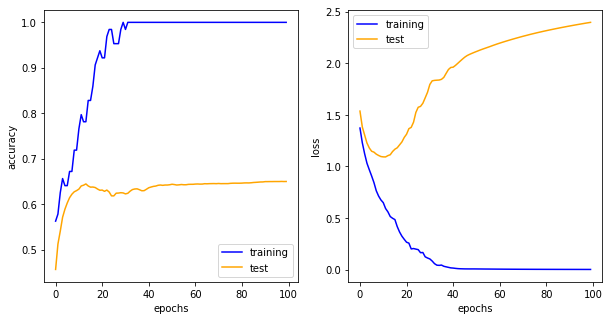

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.title('With layer normalization')
plt.subplot(121)
plt.plot(range(100), train_accuracy, color  = 'blue', label = 'training')
plt.plot(range(100), test_accuracy,  color = 'orange',label =  'test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(122)
plt.plot(range(100), train_loss, color  = 'blue', label = 'training')
plt.plot(range(100), test_loss,  color = 'orange', label = 'test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


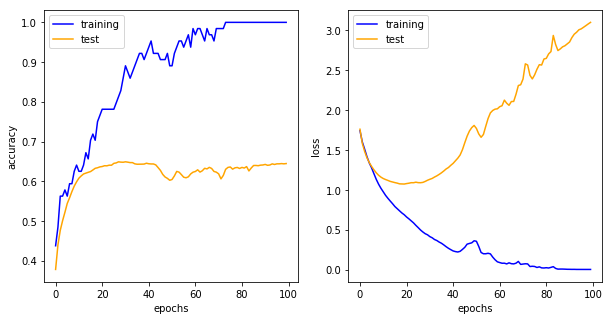

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.title('Without layer normalization')
plt.subplot(121)
plt.plot(range(100), train_accuracy, color  = 'blue', label = 'training')
plt.plot(range(100), test_accuracy,  color = 'orange',label =  'test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(122)
plt.plot(range(100), train_loss, color  = 'blue', label = 'training')
plt.plot(range(100), test_loss,  color = 'orange', label = 'test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
